<a href="https://colab.research.google.com/github/DPM-ES/proyectos_colab/blob/main/Proyecto_Final_Computer_Vision_Detecci%C3%B3n_Mano_Moneda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Detección Mano Moneda** (Introducción)

## Datos y contexto

Una de las mayores dificultades que enfrenta una joyería virtual es la obtención precisa de las medidas de los dedos de la mano de sus clientes. Éste, junto con el desafío que presenta el determinar la talla exacta de anillo que se adapte perfectamente a cada persona.

La necesidad de encontrar una solución eficaz para obtener las medidas de los dedos se convierte en un aspecto crucial de nuestra operación. Este problema no solo afecta la satisfacción del cliente, sino que también incide en la eficiencia operativa y la gestión del inventario, ya que anillos mal ajustados pueden resultar en devoluciones, intercambios y costos adicionales de envío.

## Definición del reto

Para poder sacar las medidas de la mano, en primer lugar, se utiliza un objeto como referencia, cuyas medidas sean conocidas previamente. En este caso, ese objeto es una moneda.

En primer lugar, se pretende sacar las medidas de la moneda, en píxeles, del lado máximo y del lado mínimo, ya que, según el ángulo de la foto puede no ser un círculo perfecto.

Para ello, hay que realizar los siguientes pasos:
1. Procesar la imagen
2. Segmentar la moneda
3. Sacar las medidas

En este reto solo se tendrá en cuenta esta parte, y no procederemos a cosas a futuro como:
- Clasificar la moneda
- Sacar la medida de la mano

## Posibles complicaciones a tener en cuenta

- Hay que tener en cuenta la calidad de la imagen y procesarla
- Puede no ser circular por el ángulo de la foto, sino una elipse, y en este caso habría que sacar el lado más largo y el más corto en píxeles.
- Pueden existir sombras que hacen que no sea fácil detectar el perímetro exacto de la moneda.



---


# Antes de empezar
Se requiere usar el archivo zip con las imágentes que se usarán.
Descargad las imágenes de [aquí](https://drive.google.com/u/0/uc?id=1uobq7SfZwxJ8hO87yuuVNKToay8oMyLn&export=download).

Subid el archivo a Colab y continuad con las ejecuciones.






---


# Configuración inicial

En esta sección cargaremos las configuraciones necesarias para ejecutar el proyecto, como las importaciones de librerías y datos a manejar

In [ ]:
# Importaciones de librerías
import cv2 as cv                    # Visión por computador
import matplotlib.pyplot as plt     # Trabajo con gráficos
import numpy as np                  # Trabajo con vecores
import os                           # Interfaz de sistema operativo

In [ ]:
# Una vez subida el archivo .zip con las imágenes hay que descomprimirlo
# Nota: en caso de que no se haya descargado, fallará la ejecución y no
# se podrá continuar
!unzip -o "Fotos_Mano_Moneda.zip" -d "img"



---


# Funciones auxiliares


Sección donde guardar funciones auxiliares que use más adelante

In [ ]:
# Creo un error personalizado para el caso de que se pasé una imagen inferior a
# 500 x 500. La clase no hace nada, ya que simplemente es informativo.
class SizeError(Exception):
  pass

In [ ]:
# Función para procesar imágenes
# Escala las imágenes a 500x500 y las pasa a escala de grises.
# Las imágenes dadas son muy grandes y pesadas, así que es mejor reescalarlas
# a una escala más pequeña, además, para este proyecto el color no es
# relevante, así que la pasamos a escala de grises

def porcesar_img(img):
  """
  Escala la imagen a 500x500
  También la convierte a escala de grises
  Args:
    img: imagen a procesar
  Returns:
    La imagen procesada
  """
  hi, wi, _ = img.shape
  if hi < 500 or wi < 500:
    raise SizeError("La imagen no puede tener un tamaño inferior a 500 x 500")
  if hi > wi:
    dif = int((hi - wi) / 2)
    t_img = cv.copyMakeBorder(img, 0, 0, dif, dif, cv.BORDER_CONSTANT)
  elif wi > hi:
    dif = int((wi - hi) / 2)
    t_img = cv.copyMakeBorder(img, dif, dif, 0, 0, cv.BORDER_CONSTANT)
  else:
    t_img = img
  return cv.resize(cv.cvtColor(t_img, cv.COLOR_RGB2GRAY), (500, 500))

In [ ]:
# Función para recortar la imagen respetando la proporción

def recortar_img(img):
  """
  Escala la imagen a dejándola en un tamaño cuya dimensión mayor sea inferior
  a 500px.
  Args:
    img: imagen a recortar
  Returns:
    La imagen recortada
  """
  hi, wi = img.shape
  if hi < 500 or wi < 500:
    raise SizeError("La imagen no puede tener un tamaño inferior a 500 x 500")
  if hi > wi:
    return cv.resize(img, (int(500 * wi / hi), 500))
  if hi < wi:
    return cv.resize(img, (500, int(500 * hi / wi)))
  else:
    return cv.resize(img, (500, 500))



---


# Tratamiento de imágenes

## Tamaño y color

Generalmente, las imagenes con las que se trabaja son muy pesadas por su tamaño, además, son a color, que para el ejercicio en el que estamos no lo necesitamos.

Así pues, sueles ser recomendable reducir su tamaño y quitar el color, con lo que conseguimos imágenes más ligeras que ayuda a la velocidad de procesamiento.

In [ ]:
# Cargamos las imágenes en una lista
# Uso cvtColor para ajustar los colores, paso de BGR a RGB
dir = "img/"
nombres = sorted(os.listdir(dir))
imgs = []

for nombre in nombres:
  r_img = dir + nombre
  imgs.append(cv.cvtColor(cv.imread(r_img),
                          cv.COLOR_BGR2RGB))

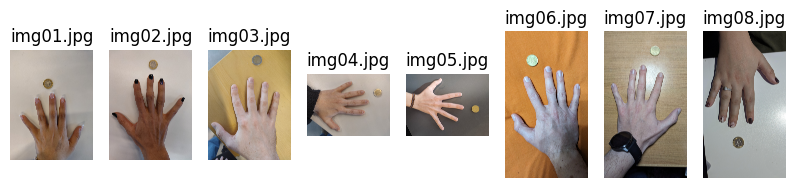

In [ ]:
# Visualización de las imágenes con las que se va a trabajar
plt.figure(figsize=(10,10))

for i in range(len(nombres)):
  plt.subplot(1, len(nombres), i+1)

  plt.imshow(imgs[i])
  plt.title(nombres[i])
  plt.axis("off")

plt.show()

In [ ]:
# Procesamos las imágenes con la función "porcesar_img" para escalarlas
# a 500x500 y convertirlas a escala de grises

g_imgs = list(map(porcesar_img, imgs))

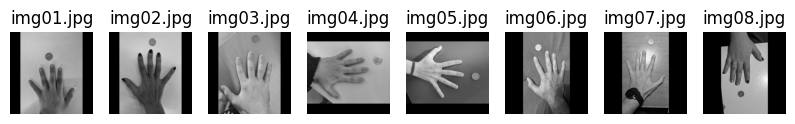

In [ ]:
# Visualización de las imágenes procesadas
plt.figure(figsize=(10,10))

for i in range(len(nombres)):
  plt.subplot(1, len(nombres), i+1)
  plt.imshow(g_imgs[i], "gray")
  plt.title(nombres[i])
  plt.axis("off")

plt.show()

## Suavizado y eliminación de ruido

Por muchas razones, las imágenes pueden tener ruido: baja calidad de la imagen, luminosidad insuficiente, textura del fondo, las arrugas naturales de la mano, etc.

Por esta razón, debemos aplicar un suavizado para minimizar el ruido y así facilitar al algoritmo encontrar la moneda y reducir los falsos positivos.

Por otro lado, existen varios métodos de suavizado, después de las pruebas, he decidido seleccionar el método **Median Blurring**, que elimina el mayor porcentaje de detalles.

In [ ]:
# Para ejecutar el suavizado Median Blurring se usa la función
# cv.medianBlur que coge como parámetros la imagen y el filtro
# ksize de la mediana

s_imgs = list(map(cv.medianBlur, g_imgs, [5] * len(g_imgs)))

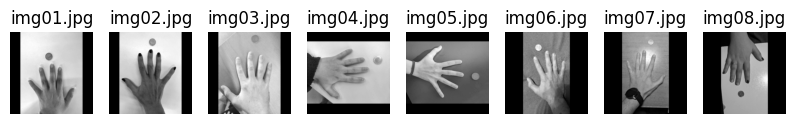

In [ ]:
# Visualización de las imágenes suavizadas
# Nota: apenas se ve diferencia porque las imágenes son muy prqueñas
# pero sí que se puede observar, aunque como comento arriba, lo importante
# es mejorar el resultado
plt.figure(figsize=(10,10))

for i in range(len(nombres)):
  plt.subplot(1, len(nombres), i+1)
  plt.imshow(s_imgs[i], "gray")
  plt.title(nombres[i])
  plt.axis("off")

plt.show()



---


# Reconocimiento de la moneda

El objetivo del proyecto es detectar la moneda y sacar su dimensión.

Esta medida serviría para usar de refetencia para sacar el tamaño de los dedos y así saber el tamaño del anillo qué pedir en un compra online, sin embargo, en este proyecto no llegaremos a este punto.

A continuación, vamos a usar el método **HoughCircles**, que usa la función de la transformada de Hought para círculos. Esta función busca los contornos de los objetos en la imagen para intentar buscar círculos.

La función coje como parámetros la imagen y otros datos como, el tamaño mínimo y máximo del círculo a buscar o una región de interes dónde hacerlo. Y devuelve un array de elementos, donde cada elemento es otro array con la posición del centro del cículo y su radio.

In [ ]:
# Vamos a crear una lista con las monedas detectas. Hay que tener en cuenta
# que los casos donde no se detecten monedas o se detecten varios falsos
# positivos se descartarán. Además, sí solo se detecta un falso positivo se
# tomará como bueno al ahora de representar, aunque en verdad sea un error.

monedas = []
for i in range(len(nombres)):
  aux = cv.HoughCircles(s_imgs[i], cv.HOUGH_GRADIENT_ALT,
                        dp=5, minDist=500,
                        param1=200, param2=0.6,
                        minRadius=10, maxRadius=40
                        )
  if aux is not None:
    aux = np.uint16(np.around(aux))
    monedas.append(aux[0][0])
  else:
    monedas.append(None)

In [ ]:
# Una vez usadas las imágenes buscando la monedas, las devolvemos a RGB
# para dibujar las moneas con color en una nueva lista para no modificar
# s_imgs por si se vuelve a necesitar
c_imgs = []

for img in s_imgs:
  c_imgs.append(cv.cvtColor(img, cv.COLOR_GRAY2BGR))

In [ ]:
for i, m in enumerate(monedas):
  if m is not None:
    # Dibuja el contorno de la moneda en verde
    cv.circle(c_imgs[i],(m[0],m[1]),m[2],(0,255,0),2)
    # Marca el centro de la moneda en rojo
    cv.circle(c_imgs[i],(m[0],m[1]),2,(255,0,0),3)

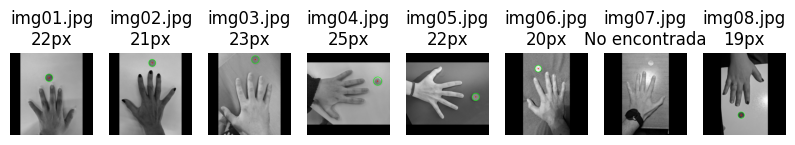

In [ ]:
# Visualización de las imágenes con las monedas resaltadas (siempre que se de
# el caso de ser detectas correctamente)
plt.figure(figsize=(10,10))

for i in range(len(nombres)):
  plt.subplot(1, len(nombres), i+1)
  plt.imshow(c_imgs[i])
  if monedas[i] is not None:
    plt.title(nombres[i] + "\nr=" + str(monedas[i][2]) + "px")
  else:
    plt.title(nombres[i] + "\n" + "No encontrada")
  plt.axis("off")

plt.show()

## Comprobar una imagen

Al usar varias imágenes es dificil ver el resultado, a continuación dejo esta celda para poder realizar la comprobación eligiendo una de las imágenes.

Existen 8 imágenes en la muestra
Puedes elegir una imagen introduciendo un número del 0 al 7
Introduce el número
 > 1


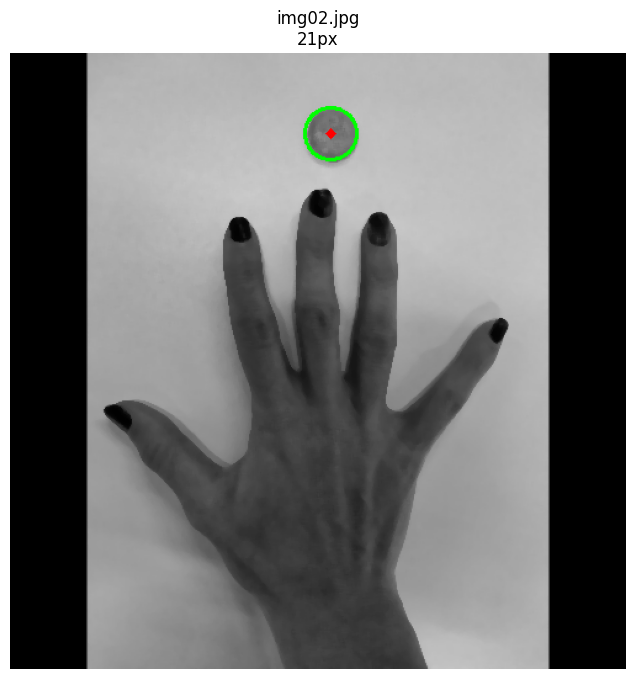

In [ ]:
print(f"Existen {len(nombres)} imágenes en la muestra")
print(f"Puedes elegir una imagen introduciendo un número del 0 al",
      len(nombres)-1)
prueba = input("Introduce el número\n > ")
try:
  i = int(prueba)
  if i < 0 or i > len(nombres):
    raise ValueError
  plt.figure(figsize=(8,8))
  plt.imshow(c_imgs[i])
  if monedas[i] is not None:
    plt.title(nombres[i] + "\nr=" + str(monedas[i][2]) + "px")
  else:
    plt.title(nombres[i] + "\n" + "No encontrada")
  plt.axis("off")
  plt.show()
except:
  print("No has introducido un valor correcto")



---

# Prueba con tu foto

En esta sección realizdo en una única celda todo el proceso mostrando solo el reultado de la prueba.

Para realizar necesias subir una foto de una mano con una moneda de **0.5, 1 o 2 €** con el nombre de **"imagen.jpg"**.

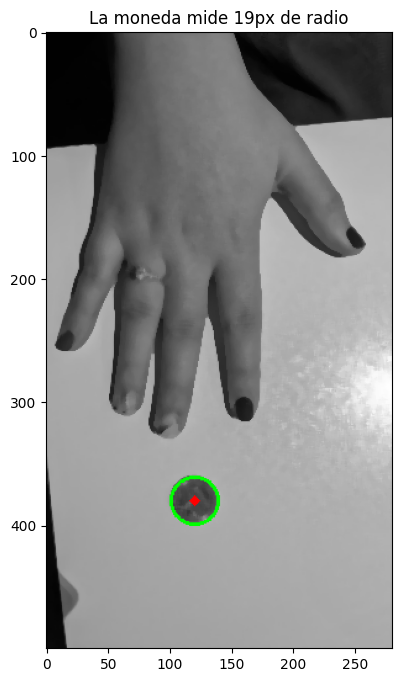

In [ ]:
try:
  img = cv.cvtColor(cv.imread("imagen.jpg"), cv.COLOR_BGR2GRAY)
  img = recortar_img(img)
  img = cv.medianBlur(img, 5)
  moneda = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT,
                          dp=5, minDist=500,
                          param1=200, param2=0.6,
                          minRadius=10, maxRadius=40
                          )
  if moneda is not None:
    moneda = np.uint16(np.around(moneda))[0][0]
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.circle(img,(moneda[0],moneda[1]),moneda[2],(0,255,0),2)
    cv.circle(img,(moneda[0],moneda[1]),2,(255,0,0),3)
    plt.figure(figsize=(8,8))
    plt.title(f"La moneda mide {moneda[2]}px de radio")
    plt.imshow(img)
    plt.show()
  else:
    print("No se ha podido encontrar la moneda")
except SizeError:
  print("La imagen debes ser de tamaño superior a 500x500")
except:
  print("Imagen no encontrada o error desconocido")